# Total variation in-painting


## Grayscale Images

A grayscale image is represented as an $m \times n$ matrix of intensities
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the values $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixel values.
Our job is to *in-paint* the image by guessing the missing pixel values,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ U_{i,j+1}-U_{ij} \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and the corrupted image and construct the Known matrix. Both images are displayed below. The corrupted image has the missing pixels whited out.

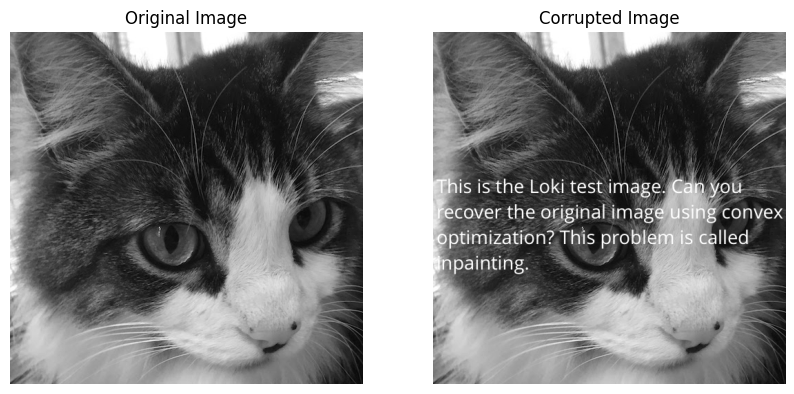

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Load the images.
u_orig = plt.imread("data/loki512.png")
u_corr = plt.imread("data/loki512_corrupted.png")
rows, cols = u_orig.shape

# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
        if u_orig[i, j] == u_corr[i, j]:
            known[i, j] = 1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(u_corr, cmap="gray")
ax[1].set_title("Corrupted Image")
ax[1].axis("off");

The total variation in-painting problem can be easily expressed in CVXPY. We use the solver SCS, which scales to larger problems than ECOS does.

In [ ]:
# Recover the original image using total variation in-painting.
import cvxpy as cp


U = cp.Variable(shape=(rows, cols))
obj = cp.Minimize(cp.tv(U))
constraints = [cp.multiply(known, U) == cp.multiply(known, u_corr)]
prob = cp.Problem(obj, constraints)

# Use SCS to solve the problem.
prob.solve(verbose=True, solver=cp.SCS)
print("optimal objective value: {}".format(obj.value))

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 23 02:06:06 PM: Your problem has 262144 variables, 1 constraints, and 0 parameters.
(CVXPY) Jun 23 02:06:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 23 02:06:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 23 02:06:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 23 02:06:06 PM: Compiling problem (target solver=SCS).
(CVXPY) Jun 23 02:06:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

After solving the problem, the in-painted image is stored in `U.value`. We display the in-painted image and the intensity difference between the original and in-painted images. The intensity difference is magnified by a factor of 10 so it is more visible.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Display the in-painted image.
ax[0].imshow(U.value, cmap="gray")
ax[0].set_title("In-Painted Image")
ax[0].axis("off")

img_diff = 10 * np.abs(u_orig - U.value)
ax[1].imshow(img_diff, cmap="gray")
ax[1].set_title("Difference Image")
ax[1].axis("off");

# Color Images

For color images, the in-painting problem is similar to the grayscale case. A color image is represented as an $m \times n \times 3$ matrix of RGB values
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the pixels $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixels. Each pixel $U^\mathrm{orig}_{ij}$ is a vector in ${\bf R}^3$ of RGB values.
Our job is to *in-paint* the image by guessing the missing pixels,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n \times 3}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ 
 U_{i,j+1}-U_{ij} 
 \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and construct the Known matrix by randomly selecting 30% of the pixels to keep and discarding the others. The original and corrupted images are displayed below. The corrupted image has the missing pixels blacked out.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
# Load the images.
u_orig = plt.imread("data/loki512color.png")
rows, cols, colors = u_orig.shape

# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
# The known matrix is initialized randomly.
known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                known[i, j, k] = 1
u_corr = known * u_orig

# Display the images.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(u_corr)
ax[1].set_title("Corrupted Image")
ax[1].axis("off");

We express the total variation color in-painting problem in CVXPY using three matrix variables (one for the red values, one for the blue values, and one for the green values). We use the solver SCS; the solvers ECOS and CVXOPT don't scale to this large problem.

In [ ]:
# Recover the original image using total variation in-painting.
import cvxpy as cp


variables = []
constraints = []
for i in range(colors):
    U = cp.Variable(shape=(rows, cols))
    variables.append(U)
    constraints.append(
        cp.multiply(known[:, :, i], U) == cp.multiply(known[:, :, i], u_corr[:, :, i])
    )

prob = cp.Problem(cp.Minimize(cp.tv(*variables)), constraints)
prob.solve(verbose=True, solver=cp.SCS)
print("optimal objective value: {}".format(prob.value))

After solving the problem, the RGB values of the in-painted image are stored in the value fields of the three variables. We display the in-painted image and the difference in RGB values at each pixel of the original and in-painted image. Though the in-painted image looks almost identical to the original image, you can see that many of the RGB values differ.

In [ ]:
import matplotlib.pyplot as plt

rec_arr = np.zeros((rows, cols, colors))
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value
rec_arr = np.clip(rec_arr, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rec_arr)
ax[0].set_title("In-Painted Image")
ax[0].axis("off")

img_diff = np.clip(10 * np.abs(u_orig - rec_arr), 0, 1)
ax[1].imshow(img_diff)
ax[1].set_title("Difference Image")
ax[1].axis("off")